In [1]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import time
import random
import os

Importing Jupyter notebook from manta_file_processing.ipynb


In [2]:
heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")

In [3]:
from importlib import reload
reload(mfp)

Importing Jupyter notebook from manta_file_processing.ipynb


<module 'manta_file_processing' from 'manta_file_processing.ipynb'>

In [4]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation
from tensorflow.python.keras.callbacks import EarlyStopping

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [5]:
image_size=[100]*2
#heatmap_size=[33]*2

In [6]:
#pip install h5py
#pip install cython
#restart jupyther
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False

In [7]:
from tensorflow.keras.models import Model

mymodel = Model(vgg16_net.get_input_at(0), vgg16_net.layers[17].get_output_at(0))
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

model=Sequential()
#model.add(vgg16_net)
#model.add(mymodel)

#input_shape=mymodel.layers[-1].output_shape[1:]
input_shape=vgg16_net.layers[-1].output_shape[1:]

model.add(BatchNormalization(input_shape=input_shape))

model.add(Conv2DTranspose(filters=256,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())
'''
model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())
'''
model.add(Conv2DTranspose(filters=5,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

heatmap_size=model.layers[-1].output_shape[1:3]
model.summary()
print("======\nHeatmap size= ",heatmap_size,"\n=====")

In [8]:
model=Sequential()
#model.add(vgg16_net)
#model.add(mymodel)

input_shape=mymodel.layers[-1].output_shape[1:]
#input_shape=vgg16_net.layers[-1].output_shape[1:]

model.add(BatchNormalization(input_shape=input_shape))

model.add(Conv2DTranspose(filters=256,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=128,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=16,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=8,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=5,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

heatmap_size=model.layers[-1].output_shape[1:3]
model.summary()
print("======\nHeatmap size= ",heatmap_size,"\n=====")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 6, 6, 512)         2048      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 10, 10, 128)       295040    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 21, 21, 64)        256       
__________

In [9]:
filename="manta_index.csv"

if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"
print("os = "+os.name)
'''
if os.path.exists(filename):
    dataset=pd.read_csv(filename)
    print("loaded from ",filename)
else:
    print("folder: "+folder+"\n ---\ncollecting...")
    dataset=mfp.get_manta_files(folder=folder)
    dataset.to_csv(filename)
'''
print("folder: "+folder+"\n ---\ncollecting...")
dataset=mfp.get_manta_files(folder=folder)

df=dataset[dataset.body_landmark_path.isnull()==False]#.sample(frac=1)
manta_data=np.array(df[["image_path","body_landmark_path"]])
#data=np.array([df.image_path,df.body_landmark_path])
print("\nData shape=",manta_data.shape)

os = nt
folder: C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some
 ---
collecting...
total:1801
labelled:295

Data shape= (295, 2)


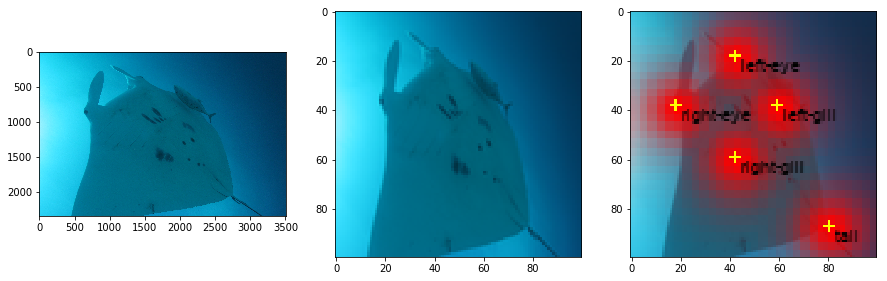

In [10]:
im_path,blm_path = manta_data[99]
image = Image.open(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)
heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size)

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 15))
axes[0].imshow(image)

image1=mfp.image_to_numpy(image,image_size)
axes[1].imshow(mfp.denormalize(image1))    
axes[2].imshow(mfp.apply_heatmaps(mfp.denormalize(image1),heatmaps)) 
plt.show()


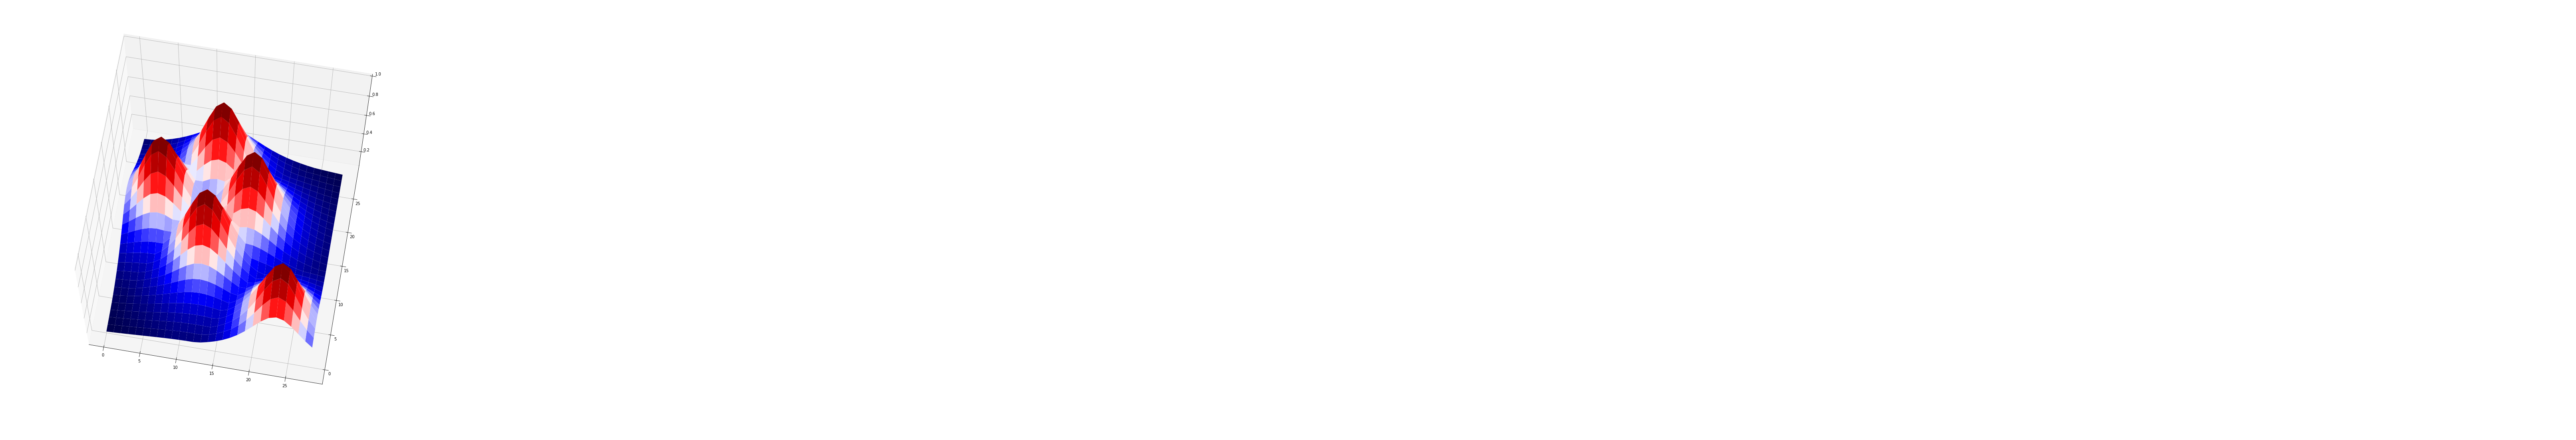

In [11]:
mfp.map3d(heatmaps.max(axis=2),alpha=70,beta=-80)

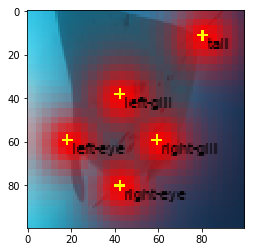

In [14]:
def flip_image(image):
    flip_image=image[::-1,:,]
    return flip_image

def flip_heatmaps(heatmaps):
    flip_heatmap=np.moveaxis(heatmaps[::-1,:,],-1,0)
    le,re,lg,rg,t=flip_heatmap
    flip_heatmap=np.array([re,le,rg,lg,t])
    flip_heatmap=np.moveaxis(flip_heatmap,0,-1)
    return flip_heatmap
    
fi,fh=flip_image(mfp.denormalize(image1)),flip_heatmaps(heatmaps)
plt.imshow(mfp.apply_heatmaps(fi,fh))

In [15]:
def load_XyF(manta_data,image_size,heatmap_size,model,rewrite=False,limit=0):
    X=[]
    y=[]
    F=[]

    #try to load data from existing files first
    features_filename = "features_"+model.name+"_"+str(image_size[0])+"x"+str(image_size[1])+".npy"
    heatmaps_filename="heatmaps"+str(heatmap_size[0])+"x"+str(heatmap_size[1])+".npy"
    
    print("trying to load fatures....")
    if os.path.exists(features_filename)==False or rewrite:
        print(features_filename, "is not exist. Will be generated.\n")
    else:
        print("loading from ",features_filename)
        F=np.load(features_filename)
        print("Successfully loaded\n")
        
    print("trying to load heatmaps....")
    if os.path.exists(heatmaps_filename)==False or rewrite:
        print(heatmaps_filename, "is not exist. Will be generated.\n")
    else:
        print("loading from ",heatmaps_filename)
        y=np.load(heatmaps_filename)
        print("Successfully loaded.\n")
        
    #loading and resizing images
    
    hm_needed=len(y)==0 or rewrite
    features_needed=len(F)==0 or rewrite
    
    i=0
    print("loading images...")
    print ("total:" + str(manta_data.shape[0]))
    
    if limit==0: limit=len(manta_data)
    for im_path,blm_path in manta_data[:limit]:
        try:
            image = Image.open(im_path)
            body_landmarks=mfp.extract_body_landmarks(blm_path)
        except:
            print(" \n Error on "+blm_path)

        image=mfp.image_to_numpy(image,image_size)
        if image.shape[2]>3:
            image=image[:,:,:3]
        if hm_needed:
            numpy_heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size=heatmap_size)

        if body_landmarks is not None:
            if hm_needed:
                y.append(numpy_heatmaps)
                flip_hm=flip_heatmaps(numpy_heatmaps)
                y.append(flip_hm)
                
            X.append(image) 
            flip_img =flip_image(image)
            X.append(flip_img) 

        print(i,end=" ")
        i+=1    
        
    print('\n')
    X=np.array(X)
    if hm_needed:
        y=np.array(y)
        np.save(heatmaps_filename,y)
        print("\nHeatmaps updated and saved to", heatmaps_filename)
    
    if features_needed:
        print("Creating features...")
        F=model.predict(X)
        np.save(features_filename,F)
        print(" \nFeatures created and saved to ", features_filename)
    
    print("\n====================")
    print("Done.\nX.shape="+str(X.shape))
    print("y.shape="+str(y.shape))
    print("F.shape="+str(F.shape))
    

    
    return X,y,F

In [16]:
#X,y,F=load_XyF(manta_data,image_size,heatmap_size,vgg16_net,rewrite=False)
#X,y,F=load_XyF(manta_data,image_size,heatmap_size,vgg16_net,rewrite=True)

X_all,y_all,F_all=load_XyF(manta_data,image_size,heatmap_size,mymodel,rewrite=False)

trying to load fatures....
loading from  features_model_100x100.npy
Successfully loaded

trying to load heatmaps....
loading from  heatmaps29x29.npy
Successfully loaded.

loading images...
total:295
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88  
 Error on C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0012 Laverna\12-F-20130627-LEI-MichelleOoi-LAVERNA-2.json
89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 

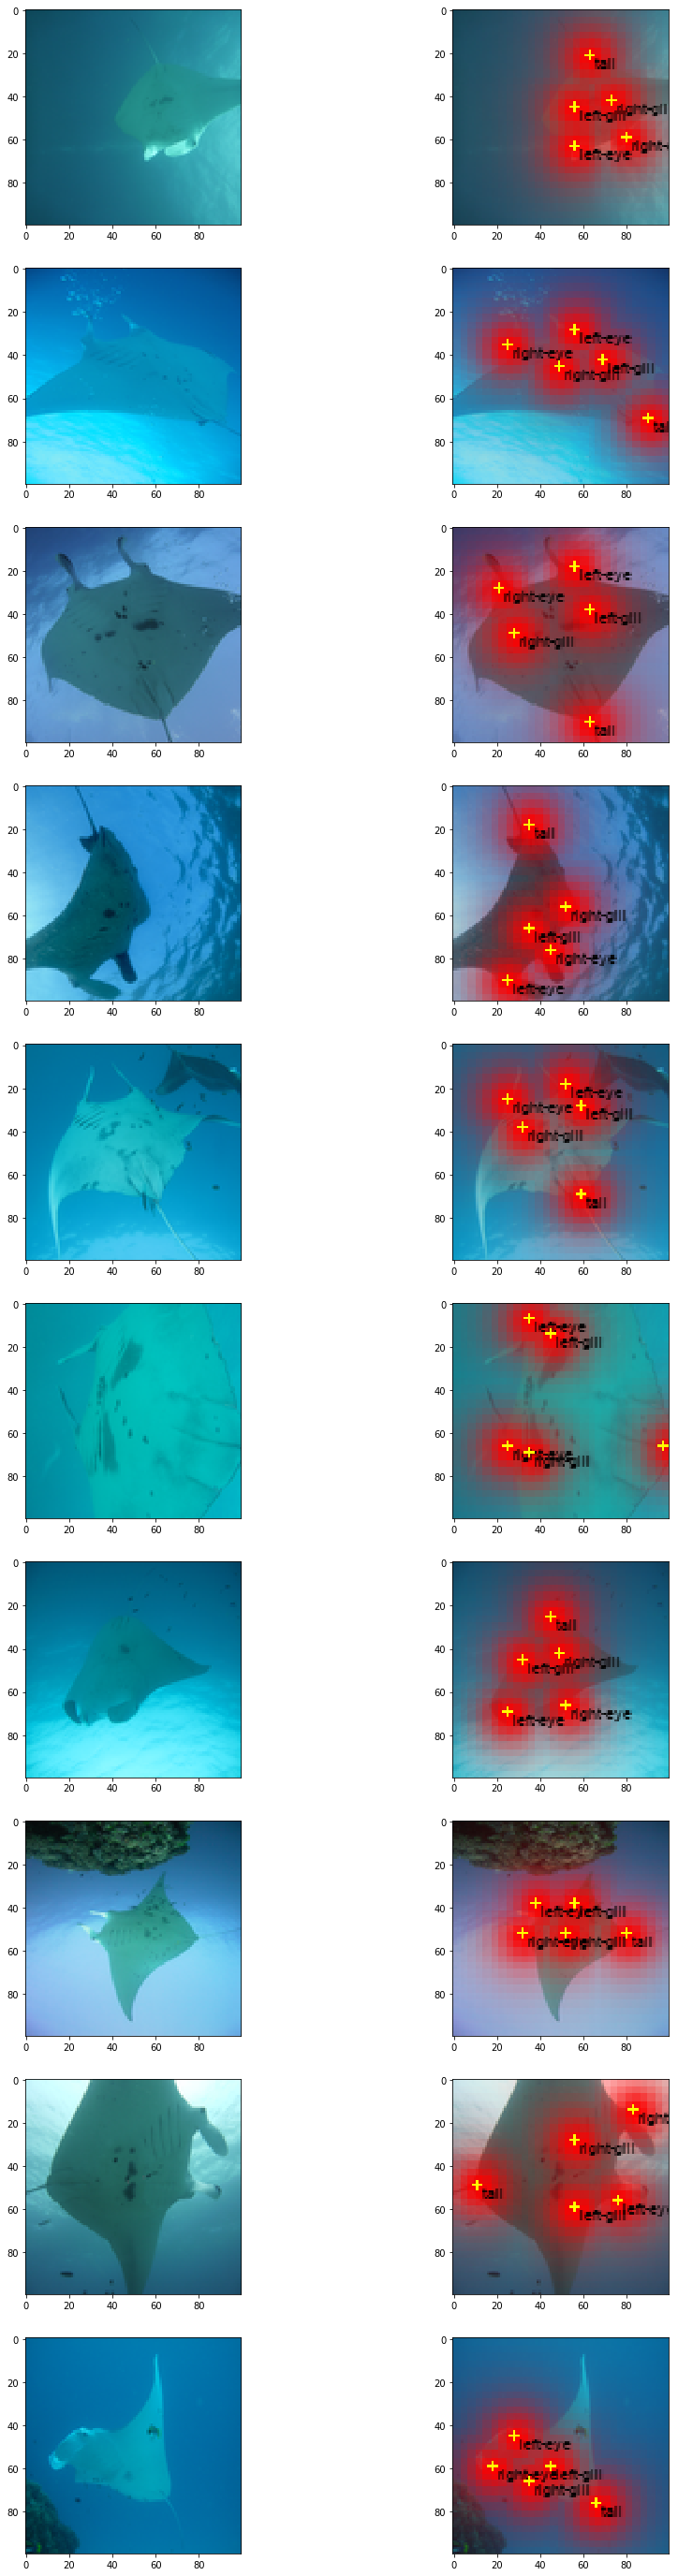

In [17]:
n=10
samples=random.sample(list(np.arange(X_all.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=2,figsize=(15, 50))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X_all[s]))
    axes[i,1].imshow(mfp.apply_heatmaps(mfp.denormalize(X_all[s]),y_all[s]))
plt.show()

In [72]:
nb_train_samples=int(round(X_all.shape[0]*0.95,0))
train_indexes=random.sample(list(range(X_all.shape[0])),nb_train_samples)
test_indexes=list(set(range(X_all.shape[0]))-set(train_indexes))

pics_train =X_all[train_indexes]
pics_test=X_all[test_indexes]

X_train=F_all[train_indexes]
X_test =F_all[test_indexes]

y_train=y_all[train_indexes]
y_test =y_all[test_indexes]

In [19]:
model.compile(loss='mse',#'binary_crossentropy',
optimizer='adam',
metrics=['mse','binary_accuracy'])

In [ ]:
#del model
#model=keras.models.load_model("model.h5")

In [20]:
start_time = time.time()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

batch_size=32
init_epochs=600

history=model.fit(X_train,y_train,batch_size=batch_size,epochs=init_epochs,validation_split=0.1,callbacks=[early_stopping_callback])

training_time=round(time.time() - start_time,0)

Train on 504 samples, validate on 56 samples
Epoch 1/600
504/504 [==============================] - 10s 19ms/step - loss: 0.1436 - mean_squared_error: 0.1436 - binary_accuracy: 0.0471 - val_loss: 0.3257 - val_mean_squared_error: 0.3257 - val_binary_accuracy: 0.0295
Epoch 2/600
504/504 [==============================] - 2s 4ms/step - loss: 0.1352 - mean_squared_error: 0.1352 - binary_accuracy: 0.0513 - val_loss: 0.2700 - val_mean_squared_error: 0.2700 - val_binary_accuracy: 0.0395
Epoch 3/600
504/504 [==============================] - 2s 4ms/step - loss: 0.1310 - mean_squared_error: 0.1310 - binary_accuracy: 0.0517 - val_loss: 0.2278 - val_mean_squared_error: 0.2278 - val_binary_accuracy: 0.0466
Epoch 4/600
504/504 [==============================] - 2s 4ms/step - loss: 0.1267 - mean_squared_error: 0.1267 - binary_accuracy: 0.0512 - val_loss: 0.1794 - val_mean_squared_error: 0.1794 - val_binary_accuracy: 0.0508
Epoch 5/600
504/504 [==============================] - 2s 4ms/step - loss: 0.

504/504 [==============================] - 2s 5ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - binary_accuracy: 0.0535 - val_loss: 0.0547 - val_mean_squared_error: 0.0547 - val_binary_accuracy: 0.0532
Epoch 39/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - binary_accuracy: 0.0535 - val_loss: 0.0531 - val_mean_squared_error: 0.0531 - val_binary_accuracy: 0.0534
Epoch 40/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - binary_accuracy: 0.0535 - val_loss: 0.0519 - val_mean_squared_error: 0.0519 - val_binary_accuracy: 0.0534
Epoch 41/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - binary_accuracy: 0.0535 - val_loss: 0.0505 - val_mean_squared_error: 0.0505 - val_binary_accuracy: 0.0533
Epoch 42/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0387 - mean_squared_error: 0.0387 - binary_accuracy: 0.

504/504 [==============================] - 2s 5ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - binary_accuracy: 0.0535 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_binary_accuracy: 0.0536
Epoch 76/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - binary_accuracy: 0.0535 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_binary_accuracy: 0.0536
Epoch 77/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - binary_accuracy: 0.0535 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_binary_accuracy: 0.0536
Epoch 78/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - binary_accuracy: 0.0535 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_binary_accuracy: 0.0536
Epoch 79/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - binary_accuracy: 0.

504/504 [==============================] - 2s 5ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - binary_accuracy: 0.0535 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_binary_accuracy: 0.0537
Epoch 113/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - binary_accuracy: 0.0535 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_binary_accuracy: 0.0537
Epoch 114/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - binary_accuracy: 0.0535 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_binary_accuracy: 0.0536
Epoch 115/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - binary_accuracy: 0.0535 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_binary_accuracy: 0.0537
Epoch 116/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - binary_accuracy

504/504 [==============================] - 2s 5ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - binary_accuracy: 0.0535 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_binary_accuracy: 0.0536
Epoch 150/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - binary_accuracy: 0.0535 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_binary_accuracy: 0.0536
Epoch 151/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - binary_accuracy: 0.0535 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_binary_accuracy: 0.0536
Epoch 152/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - binary_accuracy: 0.0535 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_binary_accuracy: 0.0536
Epoch 153/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - binary_accuracy

504/504 [==============================] - 2s 5ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - binary_accuracy: 0.0535 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_binary_accuracy: 0.0536
Epoch 187/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - binary_accuracy: 0.0535 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_binary_accuracy: 0.0536
Epoch 188/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - binary_accuracy: 0.0535 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_binary_accuracy: 0.0536
Epoch 189/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - binary_accuracy: 0.0535 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_binary_accuracy: 0.0536
Epoch 190/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - binary_accuracy

504/504 [==============================] - 2s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - binary_accuracy: 0.0535 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_binary_accuracy: 0.0536
Epoch 224/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - binary_accuracy: 0.0535 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_binary_accuracy: 0.0535
Epoch 225/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - binary_accuracy: 0.0535 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_binary_accuracy: 0.0535
Epoch 226/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - binary_accuracy: 0.0535 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_binary_accuracy: 0.0535
Epoch 227/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - binary_accuracy

504/504 [==============================] - 2s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - binary_accuracy: 0.0535 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_binary_accuracy: 0.0536
Epoch 261/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - binary_accuracy: 0.0535 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_binary_accuracy: 0.0536
Epoch 262/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - binary_accuracy: 0.0535 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_binary_accuracy: 0.0535
Epoch 263/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - binary_accuracy: 0.0535 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_binary_accuracy: 0.0536
Epoch 264/600
504/504 [==============================] - 2s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - binary_accuracy


Training time :'--- 11.0 min 23.0 sec ---


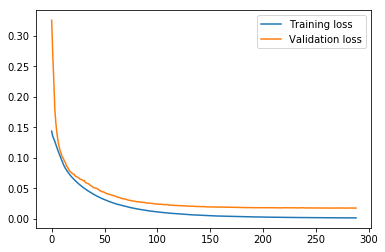

In [21]:
print("\nTraining time :'--- %s min %s sec ---" % (training_time//60,training_time%60) )
loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.show()

In [22]:
def smooth_heatmap(heatmaps,sigma=2):
    from scipy.ndimage.filters import gaussian_filter
    blured=[]
    heatmap=np.moveaxis(heatmaps,-1,0)
    for hm in heatmap:
        blured.append(gaussian_filter(hm,sigma))
    blured=np.array(blured)
    blured=np.moveaxis(blured,0,-1)
    return blured

def heatmap_error(prediction,ground_truth):
    distances=[]
    pred=np.moveaxis(prediction,-1,-0)
    gt=np.moveaxis(ground_truth,-1,-0)
    for p,g in zip(pred,gt):
        #find center of heatmap
        if gt.sum()>0:
            center=np.argmax(g)
            center_true=(center//g.shape[0],center%g.shape[1])
            
            center=np.argmax(p)
            center_pred=(center//p.shape[0],center%p.shape[1])
            
            from scipy.spatial import distance
            #print(distance.euclidean(g, p))
            distances.append(distance.euclidean(center_true, center_pred))
        else:
            distances.append(p.shape[0]*1.5)
    return np.array(distances)

In [73]:
pred=model.predict(X_test)
smoothed=np.array([smooth_heatmap(h) for h in pred])
distances=np.array([heatmap_error(t,p).mean() for t,p in zip (smoothed,y_test)])
print(X_test.shape)
print(pred.shape)
print(smoothed.shape)

(30, 6, 6, 512)
(30, 29, 29, 5)
(30, 29, 29, 5)


In [75]:
distances=pd.DataFrame(distances)
distances.columns=['error']
distances=distances.sort_values('error')
rating=distances.index
distances

error
29   0.000000
23   0.000000
2    0.000000
3    0.000000
4    0.000000
27   0.000000
6    0.000000
26   0.000000
1    0.000000
9    0.000000
13   0.000000
15   0.000000
24   0.000000
18   0.000000
8    0.000000
19   0.000000
21   0.200000
12   0.200000
7    0.200000
20   0.400000
10   0.600000
25   1.934009
16   2.574096
0    2.934009
14   3.630481
28   3.740167
17   5.600000
5    5.600000
11  14.163133
22  18.919596

2.5740963185335497


Text(0.5, 1.0, 'ground truth')

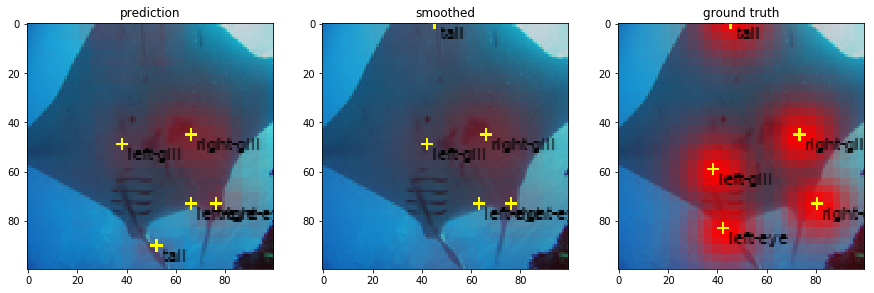

In [85]:
i=16
print(distances.error[i])
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 15))
axes[0].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_test[i]),pred[i]))
axes[0].set_title("prediction")
axes[1].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_test[i]),smoothed[i]))
axes[1].set_title("smoothed")
axes[2].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_test[i]),y_test[i]))
axes[2].set_title("ground truth")

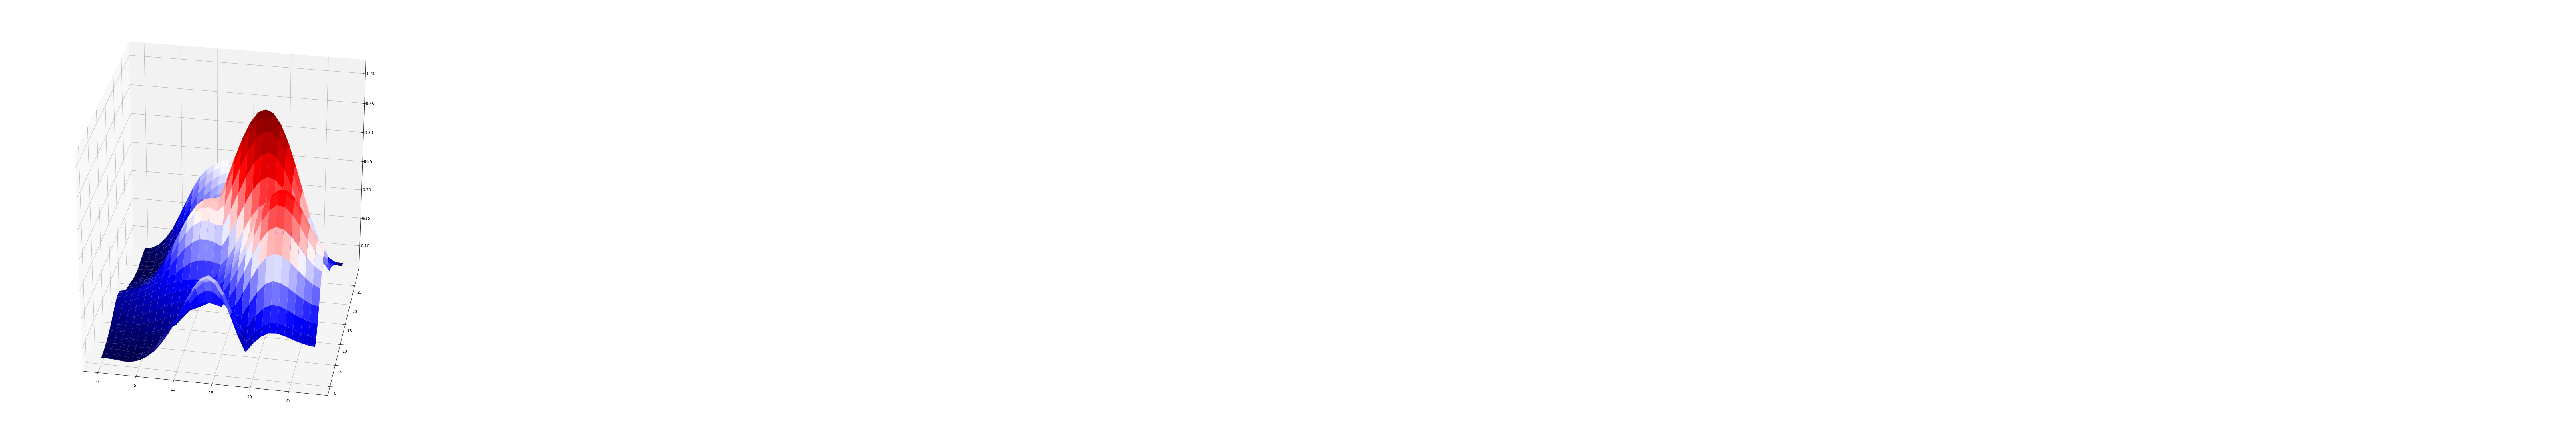

In [88]:
mfp.map3d(smoothed[i].max(axis=2))

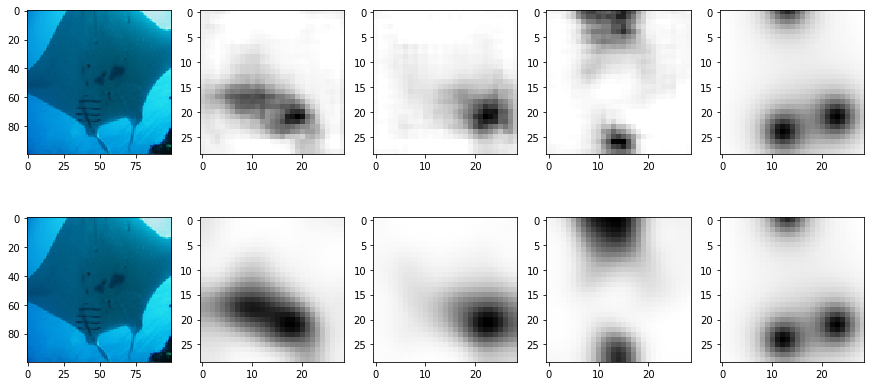

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(15, 7))
axes[0,0].imshow(mfp.denormalize(pics_test[i]))
axes[0,1].imshow(pred[i][:,:,0],cmap='Greys')
axes[0,2].imshow(pred[i][:,:,1],cmap='Greys')
#axes[i,3].imshow(pred[s][:,:,2],cmap='Greys')
axes[0,3].imshow(pred[i][:,:,4],cmap='Greys')
axes[0,4].imshow(y_test[i][:,:,[0,1,4]].sum(axis=2),cmap='Greys')

blured=smooth_heatmap(pred[i],2)

axes[1,0].imshow(mfp.denormalize(pics_test[i]))
axes[1,1].imshow(blured[:,:,0],cmap='Greys')
axes[1,2].imshow(blured[:,:,1],cmap='Greys')
#axes[i,3].imshow(pred[s][:,:,2],cmap='Greys')
axes[1,3].imshow(blured[:,:,4],cmap='Greys')
axes[1,4].imshow(y_test[i][:,:,[0,1,4]].sum(axis=2),cmap='Greys')

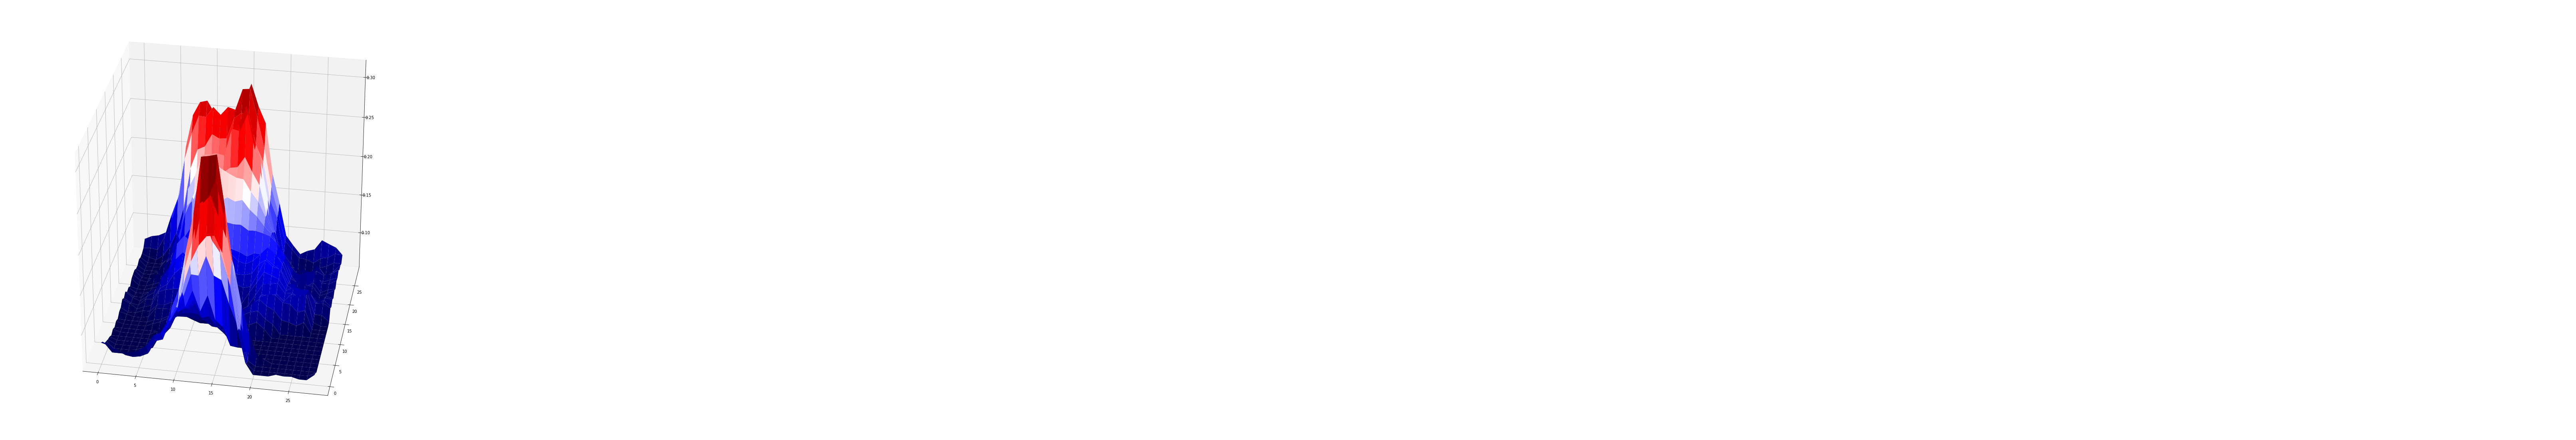

In [89]:
mfp.map3d(pred[i][:,:,4])

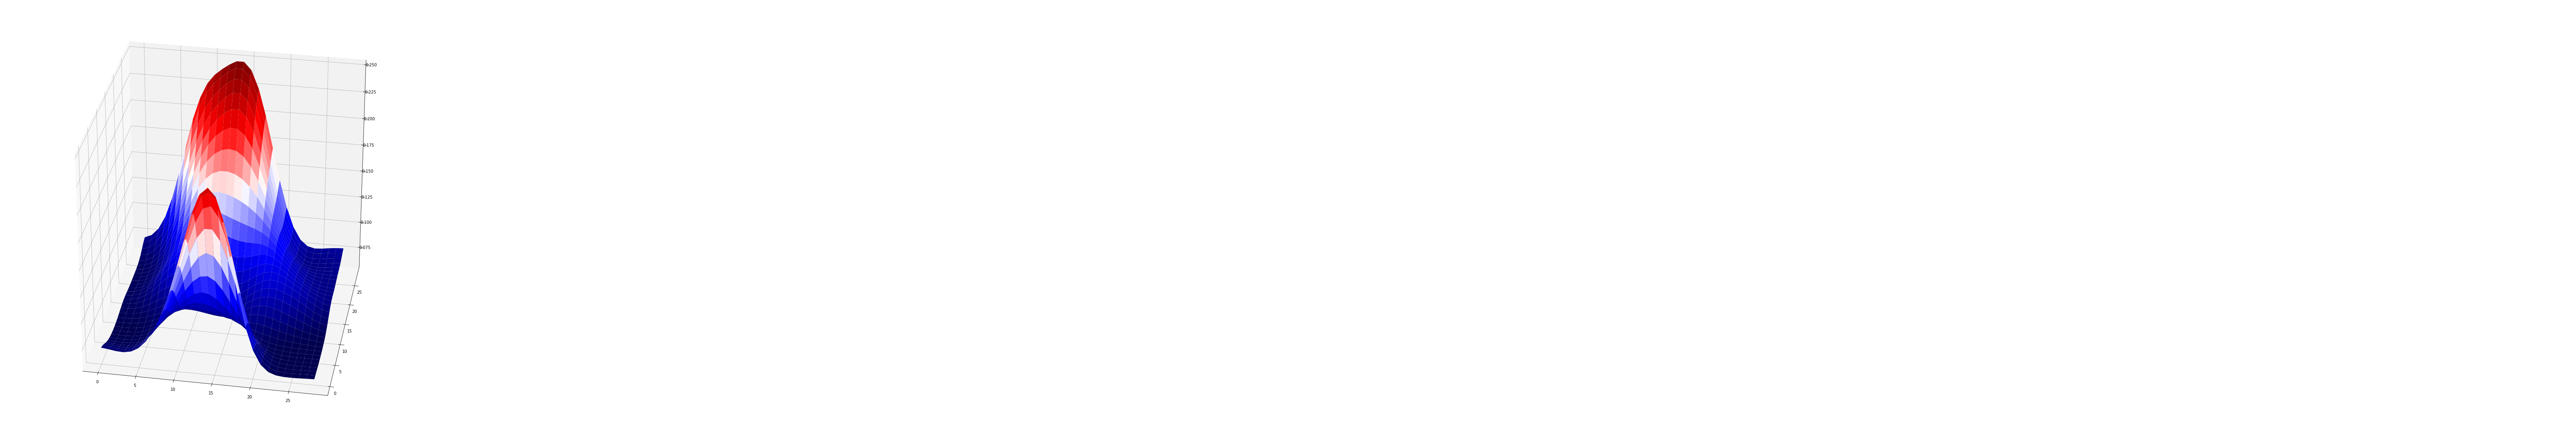

In [90]:
mfp.map3d(blured[:,:,4])

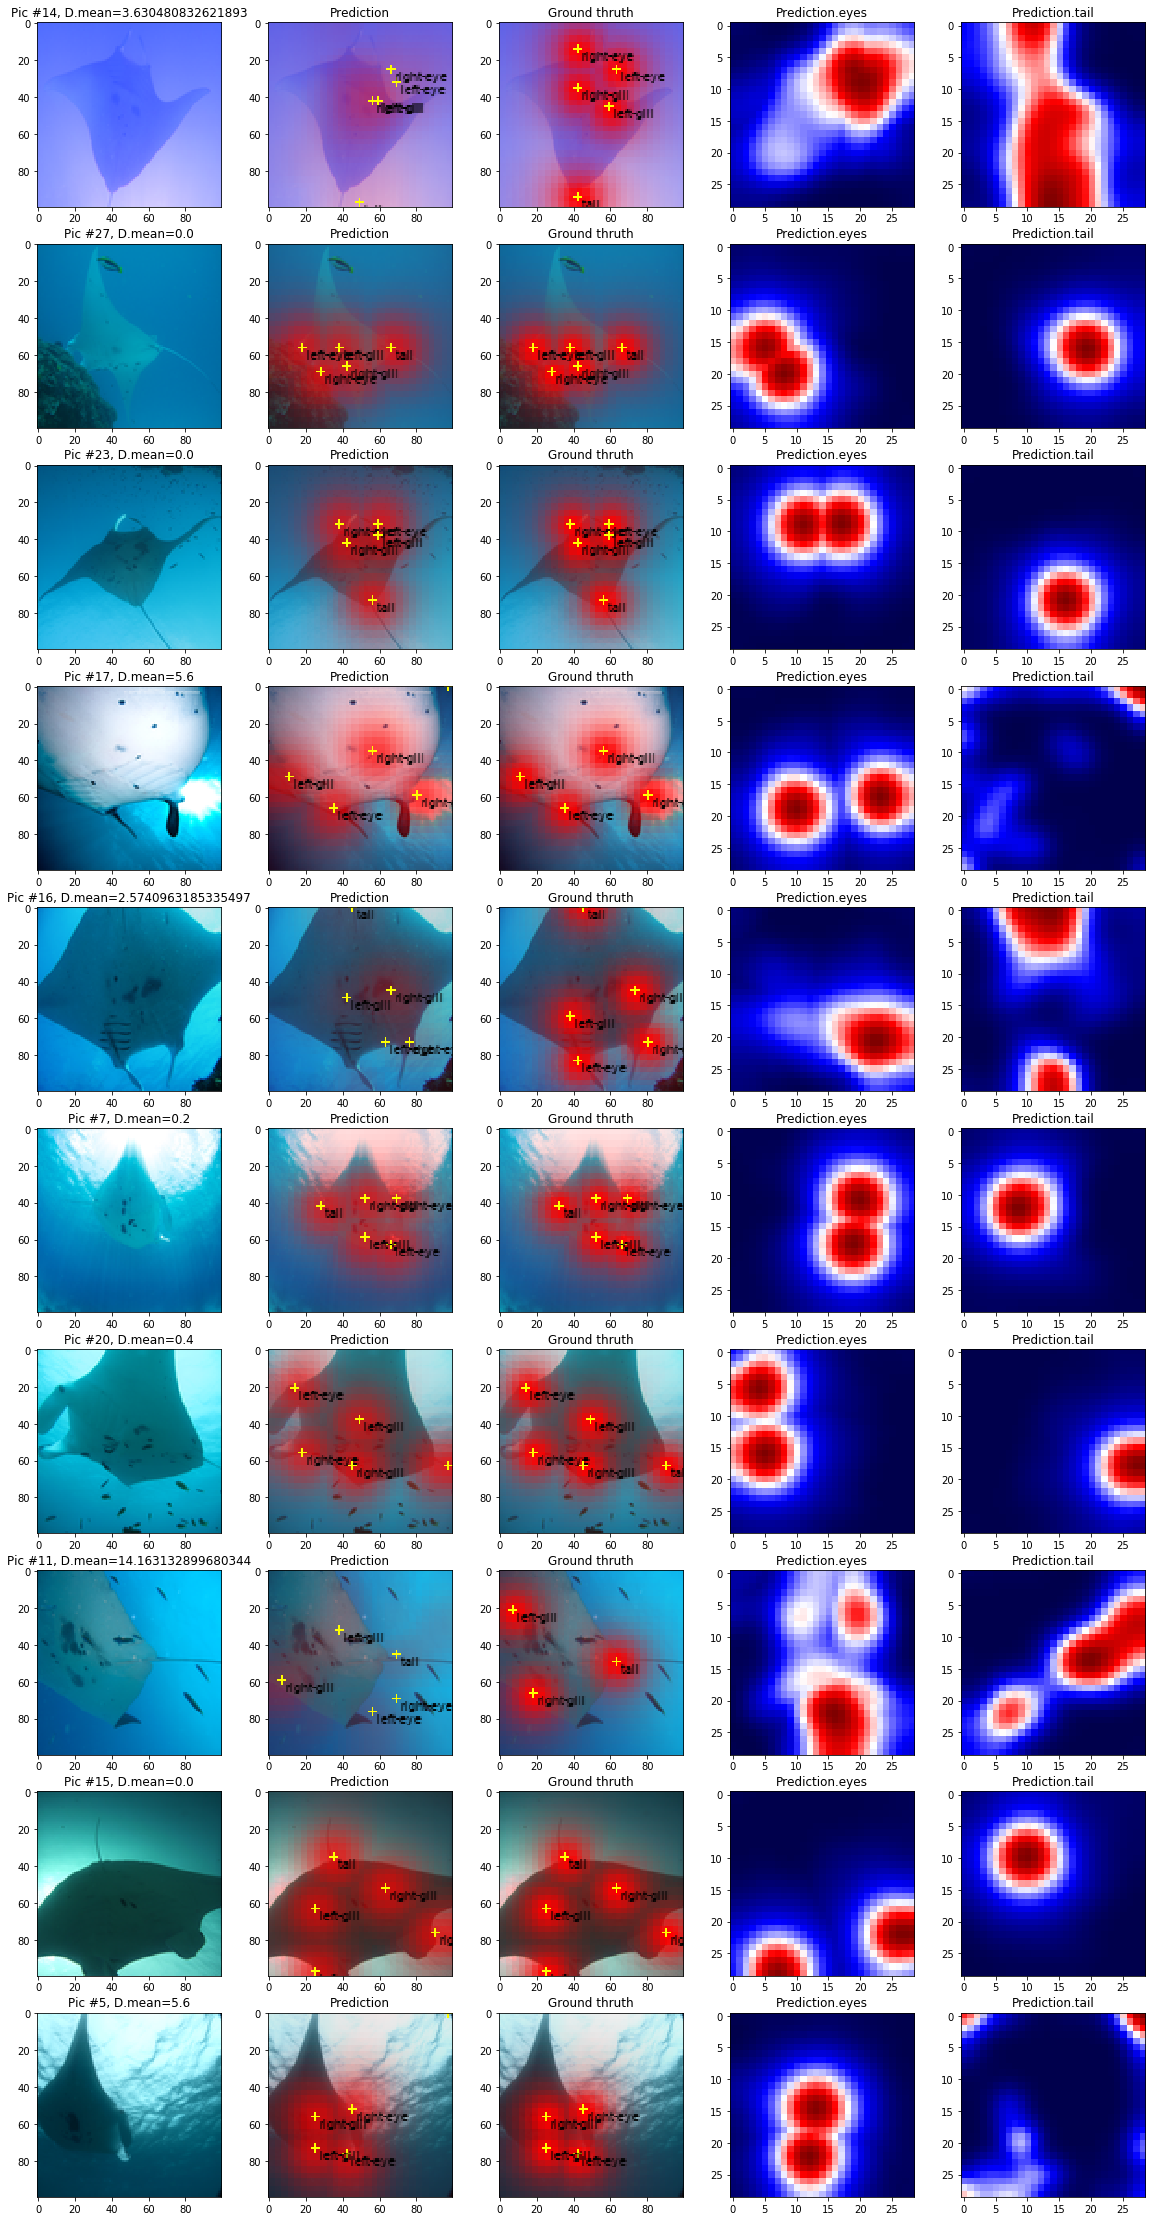

In [92]:
#random
n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=5,figsize=(20, 40))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(pics_test[s]))
    axes[i,0].set_title("Pic #"+str(samples[i])+", D.mean="+str(distances.error[samples[i]]))
    
    axes[i,1].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_test[s]),smoothed[s]))
    axes[i,1].set_title('Prediction')
    
    axes[i,2].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_test[s]),y_test[s]))
    axes[i,2].set_title('Ground thruth')
    hm=smooth_heatmap(pred[s],2)
    
    axes[i,3].imshow(hm[:,:,:2].max(axis=2),cmap='seismic')
    axes[i,3].set_title('Prediction.eyes')
    
    axes[i,4].imshow(hm[:,:,4],cmap='seismic')
    axes[i,4].set_title('Prediction.tail')


plt.show()

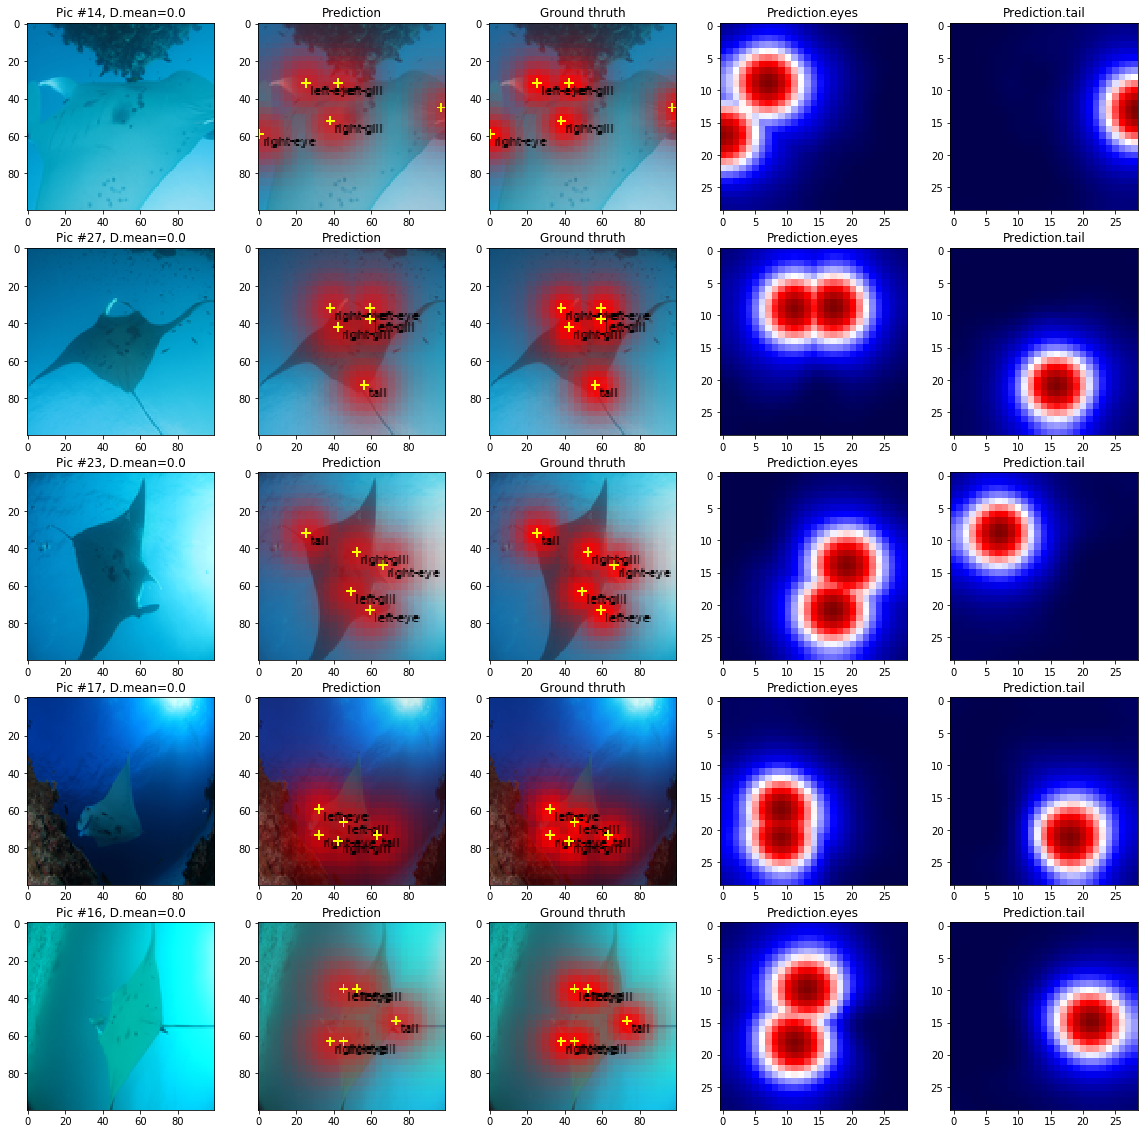

In [93]:
#best 5
qty=5

fig, axes = plt.subplots(nrows=qty, ncols=5,figsize=(20, 20))
for i,s in zip(range(qty),rating[:qty]):
    axes[i,0].imshow(mfp.denormalize(pics_test[s]))
    axes[i,0].set_title("Pic #"+str(samples[i])+", D.mean="+str(distances.error[s]))
    
    axes[i,1].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_test[s]),smoothed[s]))
    axes[i,1].set_title('Prediction')
    
    axes[i,2].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_test[s]),y_test[s]))
    axes[i,2].set_title('Ground thruth')
    hm=smooth_heatmap(pred[s],2)
    
    axes[i,3].imshow(hm[:,:,:2].max(axis=2),cmap='seismic')
    axes[i,3].set_title('Prediction.eyes')
    
    axes[i,4].imshow(hm[:,:,4],cmap='seismic')
    axes[i,4].set_title('Prediction.tail')
    
    

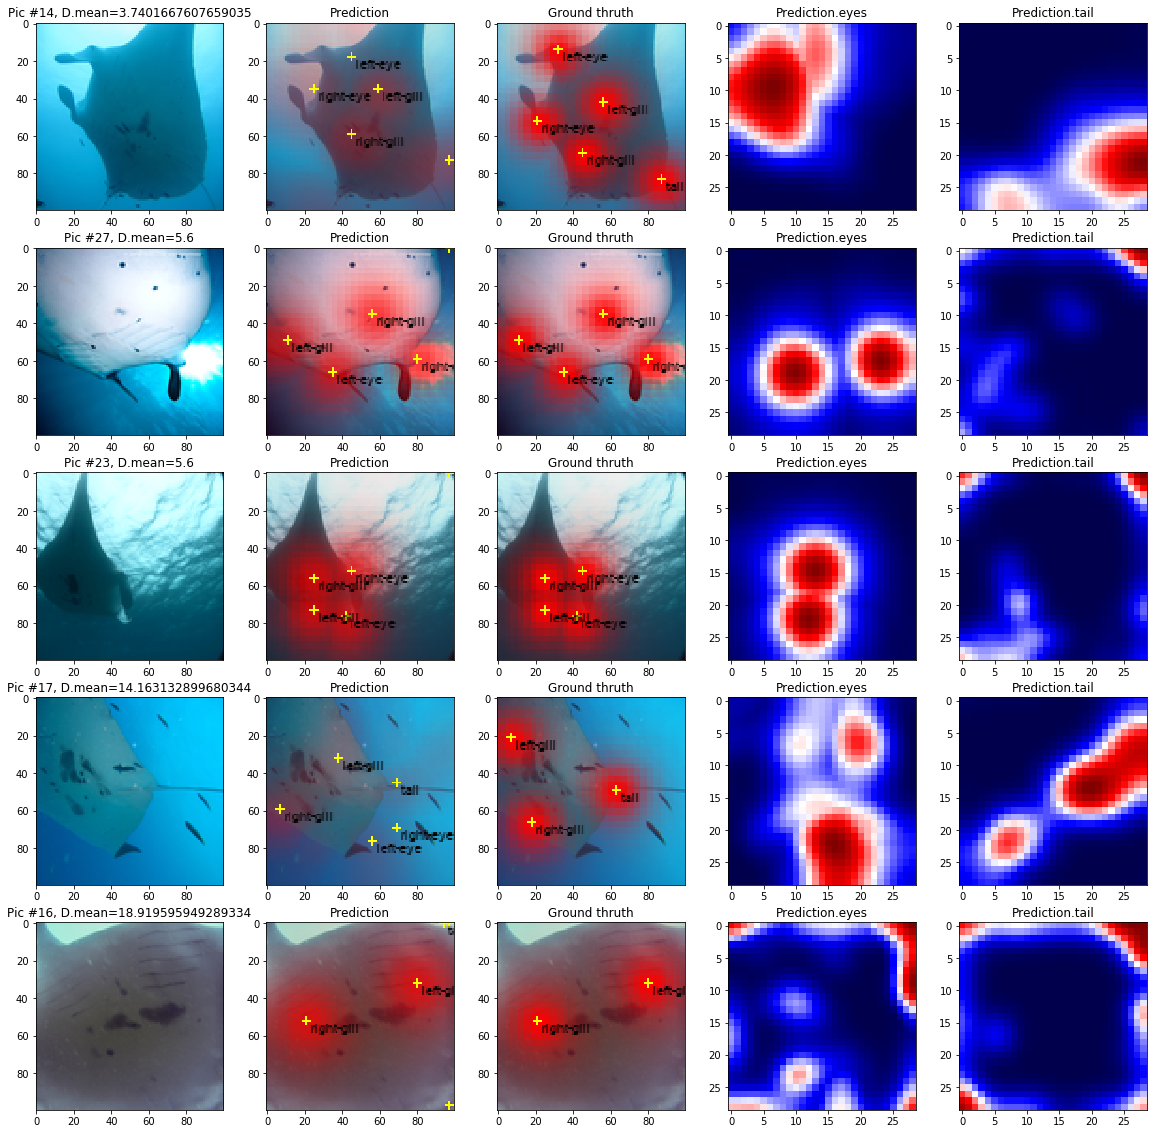

In [94]:
#worst 5
qty=5

fig, axes = plt.subplots(nrows=qty, ncols=5,figsize=(20, 20))
for i,s in zip(range(qty),rating[-qty:]):
    axes[i,0].imshow(mfp.denormalize(pics_test[s]))
    axes[i,0].set_title("Pic #"+str(samples[i])+", D.mean="+str(distances.error[s]))
    
    axes[i,1].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_test[s]),smoothed[s]))
    axes[i,1].set_title('Prediction')
    
    axes[i,2].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_test[s]),y_test[s]))
    axes[i,2].set_title('Ground thruth')
    hm=smooth_heatmap(pred[s],2)
    
    axes[i,3].imshow(hm[:,:,:2].max(axis=2),cmap='seismic')
    axes[i,3].set_title('Prediction.eyes')
    
    axes[i,4].imshow(hm[:,:,4],cmap='seismic')
    axes[i,4].set_title('Prediction.tail')

In [62]:
model.save('model_stride1_noMP.h5')

In [96]:
unknown=dataset[dataset.body_landmark_path.isnull()].image_path
unknown=np.array(unknown)
test=random.sample(list(unknown),20)

unknown_test=[]
unknown_images=[]
for f in test:
    #print(f)
    img=Image.open(f)
    im_np=mfp.image_to_numpy(img,image_size=image_size)
    unknown_images.append(im_np)

X_unknown=mymodel.predict(np.array(unknown_images))

unknown_images=np.array(unknown_images)
print(unknown_images.shape)
print(X_unknown.shape)

(20, 100, 100, 3)
(20, 6, 6, 512)


In [97]:
unknown_heatmaps=model.predict(X_unknown)
smoo_unk=np.array([smooth_heatmap(h) for h in unknown_heatmaps])

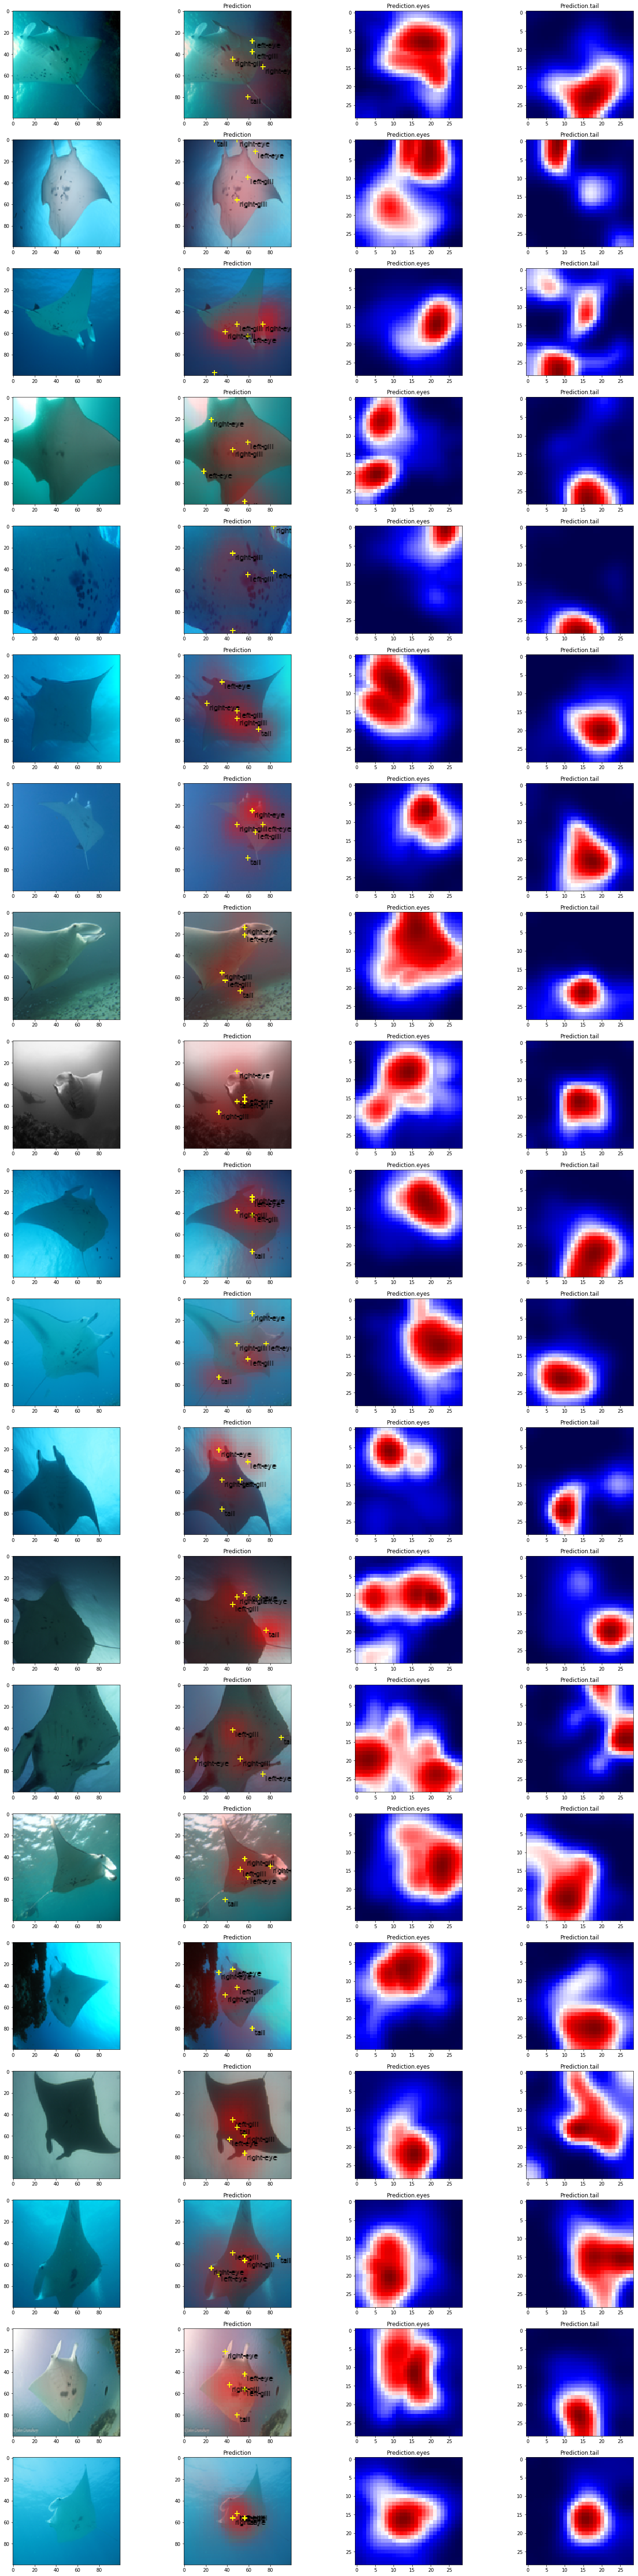

In [98]:

fig, axes = plt.subplots(nrows=20, ncols=4,figsize=(25, 100))
for i,im,h in zip(range(20),unknown_images,smoo_unk):
    axes[i,0].imshow(mfp.denormalize(im))
    #axes[i,0].set_title("Pic #"+str(samples[i])+", D.mean="+str(distances[samples[i]]))
    
    axes[i,1].imshow(mfp.apply_heatmaps(mfp.denormalize(im),h))
    axes[i,1].set_title('Prediction')
    
    #axes[i,2].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_test[s]),y_test[s]))
    #axes[i,2].set_title('Ground thruth')
    #hm=smooth_heatmap(pred[s],2)
    
    axes[i,2].imshow(h[:,:,:2].max(axis=2),cmap='seismic')
    axes[i,2].set_title('Prediction.eyes')
    
    axes[i,3].imshow(h[:,:,4],cmap='seismic')
    axes[i,3].set_title('Prediction.tail')


plt.show()


In [ ]:
Updates
week7 11.04.2018:
    -left-right update
    -heatmaps: 
        plt -> PIL.Image
        Yellow cross
        cmap="seismic"
        Gauss Filter
        3dmap
    -Metric: 
        Heatmap Peaks
        Best and worst visualisation
    -Model:
        Deep Transpose2D. stride=1
        no MaxPooling
        MSE instead of Binary crossentropy
        early stopping callback
        
Questions:
    size of 3d heatmap
    overfitting!!!!!!!!!!!!!!!!!!!!1
    save from plt.figure
    
plans:
    Keras data augmentation - no flips
    